# Data Analysis of Job tasks
When taking into account the occupation and when not taking into account the occupation, using machine learning methods such as text clustering and tokenization

Name: Joshua Hizgiaev<br>
Research: SIAI

In [30]:
!pip install nltk
!pip install transformers
!pip install seaborn
!pip install pandas numpy scipy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"


In [32]:
# Add standard data science pacakges
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# load google drive with excel sheet
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# load excel sheet data into google colab
path = '/content/drive/MyDrive/Data/Task Statements.xlsx'
task_excel = pd.DataFrame(pd.read_excel(path))
task_csv = task_excel.to_csv("/content/drive/MyDrive/Data/Task_Statements.csv",index=None,header=True)
df = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Data/Task_Statements.csv"))
df = df.sample(n=8000, random_state = 1)
print(df.shape[0])
df.reset_index(drop=True, inplace=True)
df.head()

8000


,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source
0,51-2023.00,Electromechanical Equipment Assemblers,13952,"Clean and lubricate parts and subassemblies, u...",Supplemental,68.0,07/2017,Incumbent
1,53-1043.00,First-Line Supervisors of Material-Moving Mach...,8605,Drive vehicles or operate machines or equipmen...,Core,101.0,07/2013,Incumbent
2,19-1012.00,Food Scientists and Technologists,7494,Inspect food processing areas to ensure compli...,Core,23.0,08/2020,Occupational Expert
3,19-4061.00,Social Science Research Assistants,12955,Perform descriptive and multivariate statistic...,Core,70.0,08/2019,Incumbent
4,43-9111.00,Statistical Assistants,9797,"Organize paperwork, such as survey forms or re...",Core,111.0,07/2015,Incumbent


# Preprocessing:
1. Getting rid of unneeded columns
2. Getting rid of duplicates if any
3. Getting rid of missing values if any 
4. Convert dates to date time python objects

In [35]:
df = df.drop(['O*NET-SOC Code','Task ID','Domain Source'],axis=1).drop_duplicates().dropna(how='all')
df['Date'] = pd.to_datetime(df.Date,format='%m/%Y')
df['Date'] = df['Date'].dt.strftime('%m-%Y')
print(df.shape[0])
df.head()

8000


,Title,Task,Task Type,Incumbents Responding,Date
0,Electromechanical Equipment Assemblers,"Clean and lubricate parts and subassemblies, u...",Supplemental,68.0,07-2017
1,First-Line Supervisors of Material-Moving Mach...,Drive vehicles or operate machines or equipmen...,Core,101.0,07-2013
2,Food Scientists and Technologists,Inspect food processing areas to ensure compli...,Core,23.0,08-2020
3,Social Science Research Assistants,Perform descriptive and multivariate statistic...,Core,70.0,08-2019
4,Statistical Assistants,"Organize paperwork, such as survey forms or re...",Core,111.0,07-2015


In [36]:
# Find the total amount of tasks that are core, supplemental, or neither
# this will help in understanding how the data was made, as well as what majority of the data is place or 
# if it is evenly distributed
core_df = df[df['Task Type'] == 'Core']
supp_df = df[df['Task Type'] == 'Supplemental']
neither_df = df[df['Task Type'].isna()]
print("The number of tasks identified as core: {}".format(core_df.shape[0]))
print("The number of tasks identified as supplemental: {}".format(supp_df.shape[0]))
print("The number of tasks identified as neither core or supplemental: {}".format(neither_df.shape[0]))
core_df.reset_index(drop=True, inplace=True)
supp_df.reset_index(drop=True, inplace=True)
neither_df.reset_index(drop=True, inplace=True)

The number of tasks identified as core: 5508
The number of tasks identified as supplemental: 1929
The number of tasks identified as neither core or supplemental: 563


### It is clear that there is an uneven number of core, supplemental, and tasks classified as neither
I now need to determine how exactly I should utilize this data, and how to approach it with NLP. I will first begin with **NOT** concidering occupation, meaning that I will only need to perform similarity clustering for tasks only. With that decided, I will perform NLP with the following data:
1. The data as a whole
2. The data of supplemental tasks
3. The data of core tasks
4. The data of tasks classified as neither (not core or supplemental basically)

To do so, I need to develop a Natural Language Processing model with pytorch that will allow me to create clusters based on the similarity of tasks and apply a label to each task. Meaning I will group tasks based on their similarity by assigning a numerical label to each task, every task with the same label will be in the same cluster!

In [37]:
# preprocess text data for NLP, I will begin with taking into 
# account the WHOLE dataset, and then will work on core, supplemental, and neither later
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

X = df['Task'].tolist()

documents = []
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()
for sen in range(0,len(X)):
  # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

df['Processed Tasks'] = np.array(documents)
df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Title,Task,Task Type,Incumbents Responding,Date,Processed Tasks
0,Electromechanical Equipment Assemblers,"Clean and lubricate parts and subassemblies, u...",Supplemental,68.0,07-2017,clean and lubricate part and subassemblies usi...
1,First-Line Supervisors of Material-Moving Mach...,Drive vehicles or operate machines or equipmen...,Core,101.0,07-2013,drive vehicle or operate machine or equipment ...
2,Food Scientists and Technologists,Inspect food processing areas to ensure compli...,Core,23.0,08-2020,inspect food processing area to ensure complia...
3,Social Science Research Assistants,Perform descriptive and multivariate statistic...,Core,70.0,08-2019,perform descriptive and multivariate statistic...
4,Statistical Assistants,"Organize paperwork, such as survey forms or re...",Core,111.0,07-2015,organize paperwork such a survey form or repor...
...,...,...,...,...,...,...
7995,Commercial and Industrial Designers,Develop manufacturing procedures and monitor t...,Core,54.0,08-2019,develop manufacturing procedure and monitor th...
7996,"Cooks, Institution and Cafeteria","Plan menus that are varied, nutritionally bala...",Supplemental,136.0,08-2019,plan menu that are varied nutritionally balanc...
7997,"Tailors, Dressmakers, and Custom Sewers",Sew buttonholes and attach buttons to finish g...,Core,64.0,08-2020,sew buttonhole and attach button to finish gar...
7998,Accountants and Auditors,Review accounts for discrepancies and reconcil...,Core,NaN,11-2020,review account for discrepancy and reconcile d...


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.decomposition import PCA


vectorizer = TfidfVectorizer()
processed_text = df['Processed Tasks'].tolist()
X = vectorizer.fit_transform(processed_text)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

k = 21
kmeans = KMeans(n_clusters = k,init='k-means++',max_iter=300,n_init=15, random_state=42)
kmeans.fit(X_pca)
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("The average silhouette_score is :", silhouette_avg)
df['Labels'] = kmeans.labels_
clusters = kmeans.labels_.tolist()
texts_df = pd.DataFrame({'text':processed_text,'cluster':clusters})
texts_df

The average silhouette_score is : -0.005716572180999841


,text,cluster
0,clean and lubricate part and subassemblies usi...,20
1,drive vehicle or operate machine or equipment ...,7
2,inspect food processing area to ensure complia...,11
3,perform descriptive and multivariate statistic...,3
4,organize paperwork such a survey form or repor...,9
...,...,...
7995,develop manufacturing procedure and monitor th...,1
7996,plan menu that are varied nutritionally balanc...,18
7997,sew buttonhole and attach button to finish gar...,16
7998,review account for discrepancy and reconcile d...,16


In [41]:
texts_df.to_excel('/content/drive/MyDrive/Data/output.xlsx')
X_pca.shape

(8000, 2)

In [42]:
%matplotlib inline

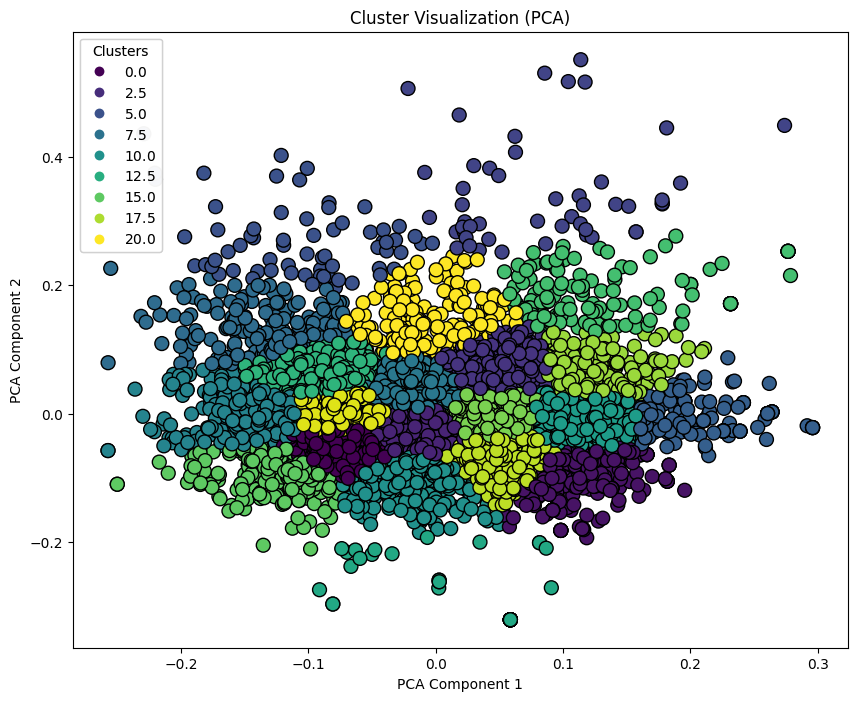

In [43]:
pca_df = pd.DataFrame(data=X_pca, columns=["PCA1", "PCA2"])
pca_df["cluster"] = clusters
plt.figure(figsize=(10, 8))
ax = plt.gca()
scatter = ax.scatter(pca_df["PCA1"], pca_df["PCA2"], c=pca_df["cluster"], cmap="viridis", edgecolors='k', s=100)
legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
ax.add_artist(legend1)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Cluster Visualization (PCA)")
plt.show()

### Now that task statements are assigned cluster labels I now want to do text classification to appoint every task description one of the following categories:

1. Technical/Engineering: Tasks involving designing, testing, and installation of devices, software, or complex equipment.

2. Management/Leadership: Tasks related to directing, overseeing, and organizing teams, projects, or departments.

3. Administrative: Tasks associated with scheduling, record-keeping, data entry, and reporting.

4. Marketing/Sales: Tasks related to promoting, selling, and creating demand for products or services.

5. Customer Service: Tasks involving interacting with customers, resolving concerns, and providing support.

6. Research/Analysis: Tasks related to gathering information, conducting studies, and evaluating findings.

7. Production: Tasks focused on manufacturing, assembly, and operations of products or machines.

8. Quality Assurance/Control: Tasks related to ensuring quality, adherence to standards, and improvement activities.

9. Human Resources: Tasks dealing with recruitment, hiring, employee relations, and training.

10. Finance/Accounting: Tasks focused on financial management, budgeting, and revenues.

11. Information Technology: Tasks associated with managing and maintaining digital systems, networks, and databases.

12. Maintenance/Repair: Tasks involving the upkeep and repair of equipment, buildings, or machinery.

13. Logistics/Supply chain: Tasks related to managing inventory, transportation, and distribution.

14. Creative/Design: Tasks involving design, creation, and innovation in various fields such as art, graphics, or products.

15. Education/Training: Tasks focused on teaching, mentoring, and skill development.

16. Health/Medical: Tasks related to patient care, treatment, and medical procedures.

17. Legal/Compliance: Tasks associated with ensuring adherence to laws and regulations.

18. Project Management: Tasks focused on planning, execution, and delivery of projects.

19. Security/Safety: Tasks related to the protection of people, property, or information.

20. Environment/Sustainability: Tasks focused on conservation, waste management, and eco-friendly processes.

# How does one do this?

Well I have the cluster labels, all I really need to do is go through the data and place the labels myself!

In [44]:
!nvidia-smi

Sun Jun 11 05:29:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    31W /  70W |   3287MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [45]:
from transformers import pipeline

categories = [
    "Technical/Engineering", "Management/Leadership", "Administrative",
    "Marketing/Sales", "Customer Service", "Research", "Production",
    "Quality Assurance/Control", "Human Resources", "Finance/Accounting",
    "Information Technology", "Maintenance/Repair", "Logistics/Supply chain",
    "Creative/Design", "Education/Training", "Health/Medical",
    "Legal/Compliance", "Project Management", "Security/Safety",
    "Environment/Sustainability", "Data Science/Analysis"
]

nlp = pipeline("zero-shot-classification", device=0)
# Function to categorize descriptions
def categorize_description(description: str) -> str:
    result = nlp(description, categories,multi_label=False)
    return result["labels"][0]
df["category"] = df["Processed Tasks"].apply(categorize_description)
df.to_excel('/content/drive/MyDrive/Data/category_output.xlsx')
df

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,Title,Task,Task Type,Incumbents Responding,Date,Processed Tasks,Labels,category
0,Electromechanical Equipment Assemblers,"Clean and lubricate parts and subassemblies, u...",Supplemental,68.0,07-2017,clean and lubricate part and subassemblies usi...,20,Maintenance/Repair
1,First-Line Supervisors of Material-Moving Mach...,Drive vehicles or operate machines or equipmen...,Core,101.0,07-2013,drive vehicle or operate machine or equipment ...,7,Maintenance/Repair
2,Food Scientists and Technologists,Inspect food processing areas to ensure compli...,Core,23.0,08-2020,inspect food processing area to ensure complia...,11,Security/Safety
3,Social Science Research Assistants,Perform descriptive and multivariate statistic...,Core,70.0,08-2019,perform descriptive and multivariate statistic...,3,Data Science/Analysis
4,Statistical Assistants,"Organize paperwork, such as survey forms or re...",Core,111.0,07-2015,organize paperwork such a survey form or repor...,9,Administrative
...,...,...,...,...,...,...,...,...
7995,Commercial and Industrial Designers,Develop manufacturing procedures and monitor t...,Core,54.0,08-2019,develop manufacturing procedure and monitor th...,1,Production
7996,"Cooks, Institution and Cafeteria","Plan menus that are varied, nutritionally bala...",Supplemental,136.0,08-2019,plan menu that are varied nutritionally balanc...,18,Creative/Design
7997,"Tailors, Dressmakers, and Custom Sewers",Sew buttonholes and attach buttons to finish g...,Core,64.0,08-2020,sew buttonhole and attach button to finish gar...,16,Production
7998,Accountants and Auditors,Review accounts for discrepancies and reconcil...,Core,NaN,11-2020,review account for discrepancy and reconcile d...,16,Research
